In [2]:
# 해당 코드는 https://woosikyang.github.io/first-post.html 을 참고하여 구성하였습니다

In [10]:
import pylab as pl
import numpy as np

import pylab as pl
import numpy as np
import pandas as pd

import torch
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

from PIL import Image
import cv2

# Swiss roll 정의 함수

In [5]:
# Swissroll 정의
def swissroll():
    N = 1000
    noise = 0.05
    t = 3 * np.pi / 2 * (1 + 2 * np.random.rand(1, N))
    h = 21 * np.random.rand(1, N)
    data = np.concatenate((t * np.cos(t), h, t * np.sin(t))) + noise * np.random.randn(3, N)
    return np.transpose(data), np.squeeze(t)

# LLE 함수

In [6]:
def LLE(data, nRedDim=2, K=12):
    ndata = np.shape(data)[0]
    ndim = np.shape(data)[1]
    d = np.zeros((ndata, ndata), dtype=float)
    for i in range(ndata):
        for j in range(i + 1, ndata):
            for k in range(ndim):
                d[i, j] += (data[i, k] - data[j, k]) ** 2
            d[i, j] = np.sqrt(d[i, j])
            d[j, i] = d[i, j]

    indices = d.argsort(axis=1)
    neighbours = indices[:, 1:K + 1]
    W = np.zeros((K, ndata), dtype=float)

    for i in range(ndata):
        Z = data[neighbours[i, :], :] - np.kron(np.ones((K, 1)), data[i, :])
        C = np.dot(Z, np.transpose(Z))
        C = C + np.identity(K) * 1e-3 * np.trace(C)
        W[:, i] = np.transpose(np.linalg.solve(C, np.ones((K, 1))))
        W[:, i] = W[:, i] / np.sum(W[:, i])

    M = np.eye(ndata, dtype=float)
    for i in range(ndata):
        w = np.transpose(np.ones((1, np.shape(W)[0])) * np.transpose(W[:, i]))
        j = neighbours[i, :]
        ww = np.dot(w, np.transpose(w))
        for k in range(K):
            M[i, j[k]] -= w[k]
            M[j[k], i] -= w[k]
            for l in range(K):
                M[j[k], j[l]] += ww[k, l]
    evals, evecs = np.linalg.eig(M)
    ind = np.argsort(evals)
    y = evecs[:, ind[1:nRedDim + 1]] * np.sqrt(ndata)
    return evals, evecs, y

# Swissroll Data 생성

In [7]:
data, t = swissroll()

#LLE

In [8]:
evals, evecs, y = LLE(data)

# Swissroll 함수 Embedding 공간 시각화

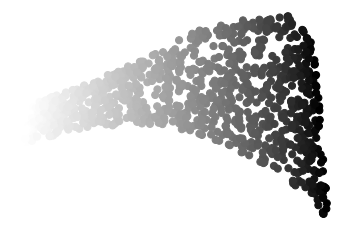

In [9]:
t2= t.min()
t3= t.max()
t = (t-t2) / (t3-t2)
pl.scatter(y[:, 0], y[:, 1], s=50, c=t, cmap=pl.cm.gray)
pl.axis('off')
pl.show()

# Mnist Dataset에 적용

# 데이터 셋 불러오기 

In [19]:
Data_set = pd.read_csv('/content/mnist_test.csv')
Data_set

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9996,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9998,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
Label_set = [str(i) for i in range(0,10)]

# Label별로 100개의 데이터만 추출하여 DataFrame 재구성

for Label in Label_set:
  globals()['label_'+str(Label)] = []
  for i in range(len(Data_set)):
    if Data_set.iloc[i,0] == int(Label):
      globals()['label_'+str(Label)].append(i)
    if len(globals()['label_'+str(Label)]) == 100:
      break 

new_Data_set = pd.DataFrame([], columns = Data_set.columns)

for i in range(10):  
  globals()['DataFrame_'+str(i)] = Data_set.iloc[globals()['label_'+str(i)],:]
  #print(globals()['DataFrame_'+str(i)])
  new_Data_set= pd.concat([new_Data_set, globals()['DataFrame_'+str(i)]])

new_Data_set = new_Data_set.reset_index(drop=True)

print(len(new_Data_set))

1000


In [21]:
List_set = [str(i) for i in range(0,10)]
for number in List_set:
    globals()['img_'+str(number)] = []
    for i in range(len(new_Data_set)):
        if new_Data_set.iloc[i,0] == int(number):
            globals()['img_'+str(number)].append(new_Data_set.iloc[i,1:].values)     
        if len(globals()['img_'+str(number)]) >=1:
            break

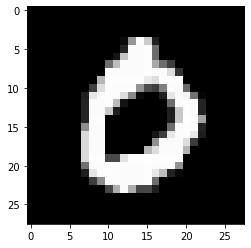

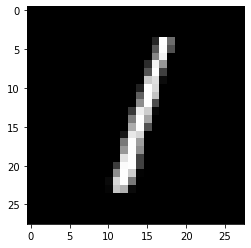

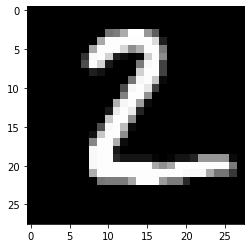

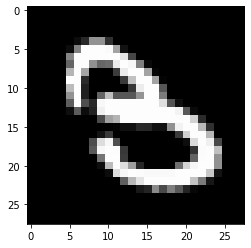

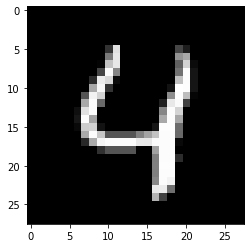

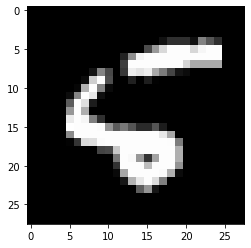

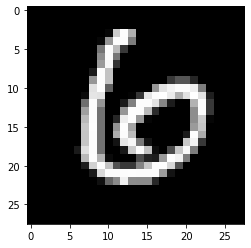

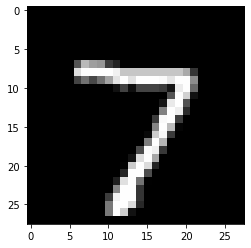

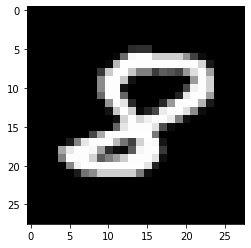

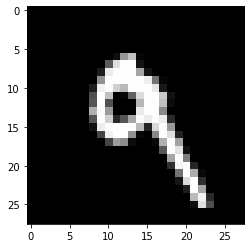

In [25]:
tf = transforms.ToTensor()
tf2 = transforms.ToPILImage()
for number in List_set:
    img = globals()['img_'+str(number)][0].astype(np.float64)
    img = img.reshape(28,28)
    img_t = tf(img)
    img_t = img_t.reshape(28,28)    
    plt.imshow(img_t,cmap='gray')
    plt.show()

# LLE 적용

In [ ]:
evals, evecs, y = LLE(new_Data_set.iloc[:,1:].values)

# 시각화

In [ ]:
B = pd.DataFrame(y)
B['Label'] = new_Data_set.iloc[:,0].values
label = B['Label'].unique()

In [ ]:
Label0 = B[B['Label']==0]
Label1 = B[B['Label']==1]
Label2 = B[B['Label']==2]
Label3 = B[B['Label']==3]
Label4 = B[B['Label']==4]
Label5 = B[B['Label']==5]
Label6 = B[B['Label']==6]
Label7 = B[B['Label']==7]
Label8 = B[B['Label']==8]
Label9 = B[B['Label']==9]

In [ ]:
# 2차원
plt.figure()  
plt.scatter(Label0.iloc[:,0],Label0.iloc[:,1],s=50, label='0')
plt.scatter(Label1.iloc[:,0],Label1.iloc[:,1],s=50, label='1')
plt.scatter(Label2.iloc[:,0],Label2.iloc[:,1],s=50, label='2')
plt.scatter(Label3.iloc[:,0],Label3.iloc[:,1],s=50, label='3')
plt.scatter(Label4.iloc[:,0],Label4.iloc[:,1],s=50, label='4')
plt.scatter(Label5.iloc[:,0],Label5.iloc[:,1],s=50, label='5')
plt.scatter(Label6.iloc[:,0],Label6.iloc[:,1],s=50, label='6')
plt.scatter(Label7.iloc[:,0],Label7.iloc[:,1],s=50, label='7')
plt.scatter(Label8.iloc[:,0],Label8.iloc[:,1],s=50, label='8')
plt.scatter(Label9.iloc[:,0],Label9.iloc[:,1],s=50, label='9')
plt.legend()

plt.show()